<a href="https://colab.research.google.com/github/mahathi-pr/price-prediction/blob/main/price%20prediction_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import zipfile
import os


drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Copy of datasheet.zip'


extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


print("Extracted files and folders:")
print(os.listdir(extract_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted files and folders:
['bluebook-for-bulldozers']


🔍 Loading and validating datasets...

Initial NaN Report:

Train NaN Summary:
auctioneerID                 20136
MachineHoursCurrentMeter    258360
UsageBand                   331486
fiSecondaryDesc             137191
fiModelSeries               344217
fiModelDescriptor           329206
ProductSize                 210775
Drive_System                296764
Enclosure                      325
Forks                       209048
Pad_Type                    321991
Ride_Control                252519
Stick                       321991
Transmission                217895
Turbocharged                321991
Blade_Extension             375906
Blade_Width                 375906
Enclosure_Type              375906
Engine_Horsepower           375906
Hydraulics                   80555
Pushblock                   375906
Ripper                      296988
Scarifier                   375895
Tip_Control                 375906
Tire_Size                   306407
Coupler                     187173
Coupler_Syst

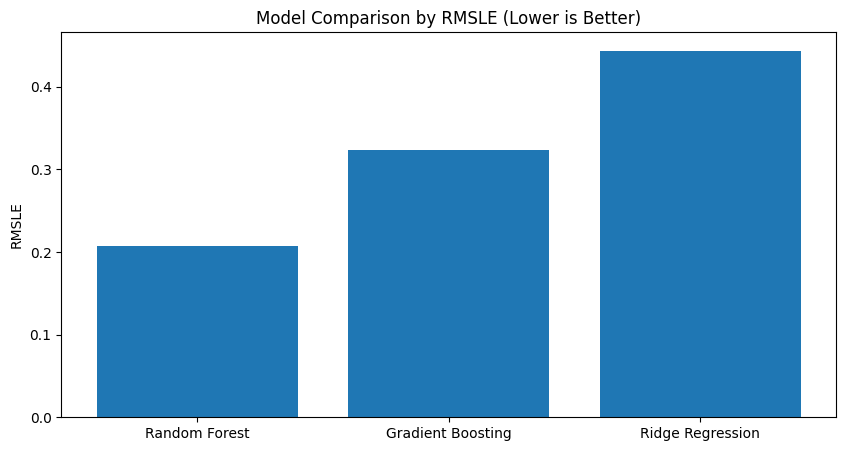


⭐ Selected best model: Random Forest

🔮 Making test predictions...

✅ Prediction Summary:
Count: 12457
Price Range: $5,257.58 to $137,326.16
Mean Price: $32,218.93

💾 Predictions saved to 'test_predictions.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Bulldozer Price Prediction
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import files


DATA_PATH = '/content/dataset/bluebook-for-bulldozers/'

def load_data():
    print(" Loading and validating datasets...")
    train = pd.read_csv(DATA_PATH + 'Train.csv', low_memory=False)
    valid = pd.read_csv(DATA_PATH + 'Valid.csv', low_memory=False)
    test = pd.read_csv(DATA_PATH + 'Test.csv', low_memory=False)


    print("\nInitial NaN Report:")
    for df, name in zip([train, valid, test], ['Train', 'Valid', 'Test']):
        print(f"\n{name} NaN Summary:")
        print(df.isnull().sum()[df.isnull().sum() > 0])

    return train, valid, test


def preprocess_data(train, valid, test):
    print("\n🧹 Cleaning and preprocessing data...")


    for df in [train, valid, test]:
        df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce')
        df['sale_year'] = df['saledate'].dt.year.fillna(df['saledate'].dt.year.median())
        df['sale_month'] = df['saledate'].dt.month.fillna(df['saledate'].dt.month.median())


    yearmade_median = train['YearMade'].replace(1000, np.nan).median()
    for df in [train, valid, test]:
        df['YearMade'] = df['YearMade'].replace(1000, np.nan).fillna(yearmade_median)
        if 'MachineHoursCurrentMeter' in df.columns:
            df['MachineHoursCurrentMeter'] = df['MachineHoursCurrentMeter'].fillna(0)


    initial_count = len(train)
    train = train.dropna(subset=['SalePrice'])
    if len(train) < initial_count:
        print(f"Removed {initial_count - len(train)} rows with missing SalePrice")


    y_train = np.log1p(train['SalePrice'])
    cols_to_drop = ['SalesID', 'MachineID', 'saledate', 'SalePrice']
    X_train = train.drop(cols_to_drop, axis=1)
    X_valid = valid.drop(cols_to_drop[:-1], axis=1)
    X_test = test.drop(cols_to_drop[:-1], axis=1)

    return X_train, y_train, X_valid, X_test


def encode_categoricals(X_train, X_valid, X_test):
    print("\n🔢 Encoding categorical variables...")
    categorical_cols = X_train.select_dtypes(include=['object']).columns

    for col in categorical_cols:

        X_train[col] = X_train[col].fillna('missing').astype(str)
        X_valid[col] = X_valid[col].fillna('missing').astype(str)
        X_test[col] = X_test[col].fillna('missing').astype(str)


        all_categories = set(X_train[col]).union(set(X_valid[col])).union(set(X_test[col]))


        le = LabelEncoder()
        le.fit(list(all_categories) + ['unknown'])


        for df in [X_train, X_valid, X_test]:
            df[col] = df[col].apply(lambda x: x if x in le.classes_ else 'unknown')
            df[col] = le.transform(df[col])


    num_imputer = SimpleImputer(strategy='median')
    numeric_cols = X_train.select_dtypes(include=np.number).columns
    X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
    X_valid[numeric_cols] = num_imputer.transform(X_valid[numeric_cols])
    X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

    return X_train, X_valid, X_test


def compare_models(X_train, y_train, X_valid, y_valid):
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'Ridge Regression': Ridge()
    }

    results = []
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)


        val_preds = model.predict(X_valid)
        rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_valid), np.expm1(val_preds)))
        mae = mean_absolute_error(np.expm1(y_valid), np.expm1(val_preds))

        results.append({
            'Model': name,
            'RMSLE': rmsle,
            'MAE': f"${mae:,.2f}"
        })

        print(f"Validation RMSLE: {rmsle:.4f}")
        print(f"Validation MAE: ${mae:,.2f}")

    return pd.DataFrame(results)

try:

    train, valid, test = load_data()


    X_train, y_train, X_valid, X_test = preprocess_data(train, valid, test)


    X_train, X_valid, X_test = encode_categoricals(X_train, X_valid, X_test)


    print("\n✅ Final NaN Check:")
    print("Training NaN:", X_train.isnull().sum().sum())
    print("Validation NaN:", X_valid.isnull().sum().sum())
    print("Test NaN:", X_test.isnull().sum().sum())


    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=0.2,
        random_state=42
    )


    print("\n MODEL COMPARISON")
    results = compare_models(X_train, y_train, X_val, y_val)


    print("\n Model Performance Comparison:")
    print(results.to_markdown())

    plt.figure(figsize=(10, 5))
    plt.bar(results['Model'], results['RMSLE'])
    plt.title('Model Comparison by RMSLE (Lower is Better)')
    plt.ylabel('RMSLE')
    plt.show()


    best_model_name = results.loc[results['RMSLE'].idxmin(), 'Model']
    print(f"\n Selected best model: {best_model_name}")

    if best_model_name == 'Random Forest':
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    elif best_model_name == 'Gradient Boosting':
        model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    else:
        model = Ridge()


    X_full = pd.concat([X_train, X_val])
    y_full = pd.concat([y_train, y_val])
    model.fit(X_full, y_full)


    print("\n🔮 Making test predictions...")
    test_preds = model.predict(X_test)


    submission = pd.DataFrame({
        'SalesID': test['SalesID'],
        'SalePrice': np.expm1(test_preds)
    })


    print("\n✅ Prediction Summary:")
    print(f"Count: {len(submission)}")
    print(f"Price Range: ${submission['SalePrice'].min():,.2f} to ${submission['SalePrice'].max():,.2f}")
    print(f"Mean Price: ${submission['SalePrice'].mean():,.2f}")

    submission.to_csv('test_predictions.csv', index=False)
    print("\n Predictions saved to 'test_predictions.csv'")
    files.download('test_predictions.csv')


In [ ]:

preds = pd.read_csv('test_predictions.csv')


print("Prediction Statistics:")
print(preds['SalePrice'].describe())
train = pd.read_csv('/content/dataset/bluebook-for-bulldozers/Train.csv')
print("\nTraining Data Statistics:")
print(train['SalePrice'].describe())

Prediction Statistics:
count     12457.000000
mean      32218.925631
std       23915.057125
min        5257.577060
25%       14106.723616
50%       23903.223652
75%       42441.410477
max      137326.160599
Name: SalePrice, dtype: float64


<ipython-input-11-751671831>:9: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/content/dataset/bluebook-for-bulldozers/Train.csv')



Training Data Statistics:
count    401125.000000
mean      31099.712848
std       23036.898502
min        4750.000000
25%       14500.000000
50%       24000.000000
75%       40000.000000
max      142000.000000
Name: SalePrice, dtype: float64
